# Алгоритм подбора упаковки под товар

## Описание проекта и задача

Общее описание задачи: Для того, чтобы пользователь получил
заказ, необходимо упаковать заказанные товары в посылки конечному клиенту.
Компания заметила, что сотрудник тратит большое количество времени для
выбора упаковочного материала в который необходимо упаковать товары.
Существует большое количество упаковочного материала (коробочки,
пакетики). **Необходимо придумать способ подсказывать пользователю
информацию о выборе упаковочного материала.**

Есть набор данных:
* описании товара,
* категории товаров,
* ВГХ (весогабаритные характеристики) товаров,
* история предыдущих выборов сотрудников.

Необходимо разработать классификационную модель, которая позволит
подсказывать, а какой заказ упаковывать в коробки, а какие в пакетики.
При этом заказ может упаковываться в различные посылки и наша задача
минимизировать их колличество.
Выводить оценку качества модели.

### Описание данных

**Заказы (`data.csv`)**
Информация по заказам и товарам (sku), которые в них содержатся:
* `whs` - код сортировочного центра;
* `orderkey` - id заказа;
* `selected_cartontype` - код упаковки, которая была выбрана пользователем;
* `box_num` - количество коробок;
* `recommended_cartontype` - код упаковки, рекомендованной алгоритмом;
* `selected_carton` - код упаковки, которая была выбрана пользователем (дубль);
* `sel_calc_cube` - объём выбранной упаковки;
* `recommended_carton` - код упаковки, рекомендованной алгоритмом (дубль);
* `pack_volume` - рассчитанный объём упакованных товаров;
* `rec_calc_cube` - (?)
* `goods_wght` - вес товара;
* `sku` - id товара;
* `who` - упаковщик;
* `trackingid` - id доставки;

**SKU (sku.csv)**
Выгрузка id товаров и их размеров.
* `sku` - id товара
* `a`, `b`, `c`, - размеры

**Карготипы товаров (sku_cargotypes.csv)**
Выгрузка id товаров и их карготипов.
* `sku` -  id товара
* `cargotype` - карготип товара

**Описание карготипов (cargotype_info.csv)**
Таблица с идентификаторами карготипов и их описаниями
* `cargotype` -  карготип
* `description` - описание

**Характеристики упаковок (carton.csv)**
Таблица с идентификаторами и линейными размерами упаковок.
* `CARTONTYPE` - идентификатор (код) упаковки;
* `LENGTH`, `WIDTH`, `HEIGTH` - линейные размеры упаковки;
* `DISPLAYFRACK` - коробка есть на складе (не учитывать для наших целей).

**Стоимость упаковок (carton_price.xlsx)**
Таблица с идентификаторами упаковок и их стоимостью.
* идентификатор (код) упаковки
* стоимость 

### Формат выдачи

По итогу проектирования ML-продукта специалисты Data Science сформируют Docker Container: web сервис, в котором реализовано два обработчика событий (”ручки” / handler):
* `/health` - GET запрос без входных параметров. Ответ: `{”status”: “ok”}`
* `/pack` -  GET запрос, который принимает параметры заказа и возвращает рекомендованную упаковку.

https://github.com/jakubmonhart/mil_pytorch


https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset


https://github.com/CTUAvastLab/Mill.jl#what-is-multiple-instance-learning-mil-problem


https://www.google.com/search?q=multi+instance+learning+pytorch&sxsrf=APwXEdc74aOvtQ4RD_Tl0NcqH018XEiu7Q%3A1686751801205&ei=OcqJZJeZDJPVrgTCypCgCA&oq=Multi+Instance+Learning+&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQARgAMgcIABATEIAEMgcIABATEIAEMgcIABATEIAEMgcIABATEIAEMggIABAWEB4QEzIICAAQFhAeEBMyCggAEBYQHhAPEBMyCAgAEBYQHhATMggIABAWEB4QEzIICAAQFhAeEBM6CggAEEcQ1gQQsAM6CggAEIoFELADEENKBAhBGABQtBZYtBZgpSBoAnABeACAAa0BiAGtAZIBAzAuMZgBAKABAcABAcgBBQ&sclient=gws-wiz-serp

## Импорт библиотек

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
#from skimpy import skim

from catboost import CatBoostRegressor, CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.utils.class_weight import compute_class_weight

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from lightgbm import LGBMClassifier

from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.svm import LinearSVC

# для нейронки
from sklearn.preprocessing import LabelEncoder

# для 3д
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [3]:
import matplotlib as mlp

sns.set_theme(style='darkgrid', palette='rocket')

mlp.rcParams['axes.labelsize'] = 10
mlp.rcParams['axes.titlesize'] = 15

pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [4]:
RANDOM = 42

## Загрузка данных

In [5]:
cargotype_info = pd.read_csv('data/cargotype_info.csv', index_col='Unnamed: 0')
carton_price = pd.read_excel('data/carton_price.xlsx', index_col='Unnamed: 0')
carton = pd.read_csv('data/carton.csv')
data = pd.read_csv('data/data.csv', index_col='Unnamed: 0')
sku_cargotypes = pd.read_csv('data/sku_cargotypes.csv', index_col='Unnamed: 0')
sku = pd.read_csv('data/sku.csv', index_col='Unnamed: 0')

#### cargotype_info 

In [6]:
cargotype_info

,cargotype,description
0,770.0,консервы
1,301.0,тяжеловесный и крупногабаритный 20кг
2,980.0,Требует обязательной маркировки
3,985.0,"Не требует наличия маркировки, но требует выво..."
4,990.0,Потребует обязательной маркировки в ближайшем ...
5,910.0,интим товар
6,900.0,медикаменты
7,10.0,документы и ценные бумаги
8,50.0,предметы искусства
9,100.0,товары народного потребления


Категории указаны смешано имеются как характериситики товара, тип товара, размер товара, тип склада, тип упаковки. Некоторые категории подразумевают на конкретный тип упаковки, далее проверим распределение упаковок для каждого типа товара, чтобы выбрать те в которых предпочтение склоняется в стоорону нескольких конкретных типов

Есть два значения NaN с датой удалим их

In [7]:
cargotype_info = cargotype_info.dropna()

#### carton_price

In [8]:
carton_price.columns = ['price']
carton_price

,price
MYA,1.109861
MYB,2.297432
MYC,3.616713
MYD,6.918375
MYE,8.062722
MYF,4.083130
YMA,4.392937
YMC,7.777487
YME,23.670260
YMF,10.661487


In [9]:
carton_price['paket'] = carton_price.index.str.startswith(('M'))

In [10]:
carton_price

,price,paket
MYA,1.109861,True
MYB,2.297432,True
MYC,3.616713,True
MYD,6.918375,True
MYE,8.062722,True
MYF,4.083130,True
YMA,4.392937,False
YMC,7.777487,False
YME,23.670260,False
YMF,10.661487,False


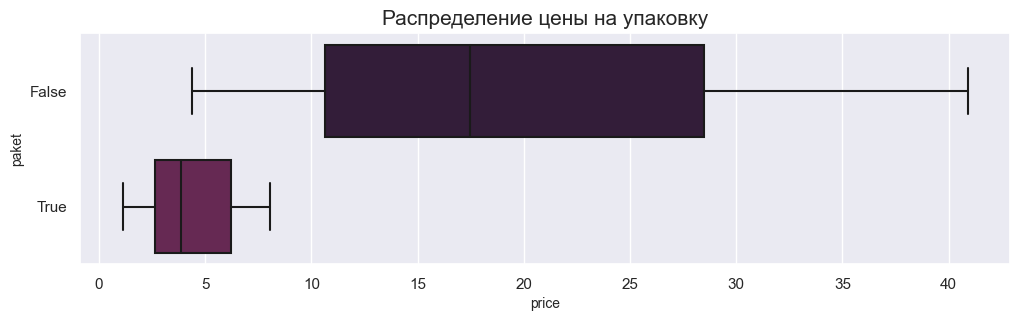

In [11]:
plt.figure(figsize=(12,3))
plt.title('Распределение цены на упаковку')

sns.boxplot(
    data=carton_price, 
    x='price', 
    y='paket', 
    orient='h');

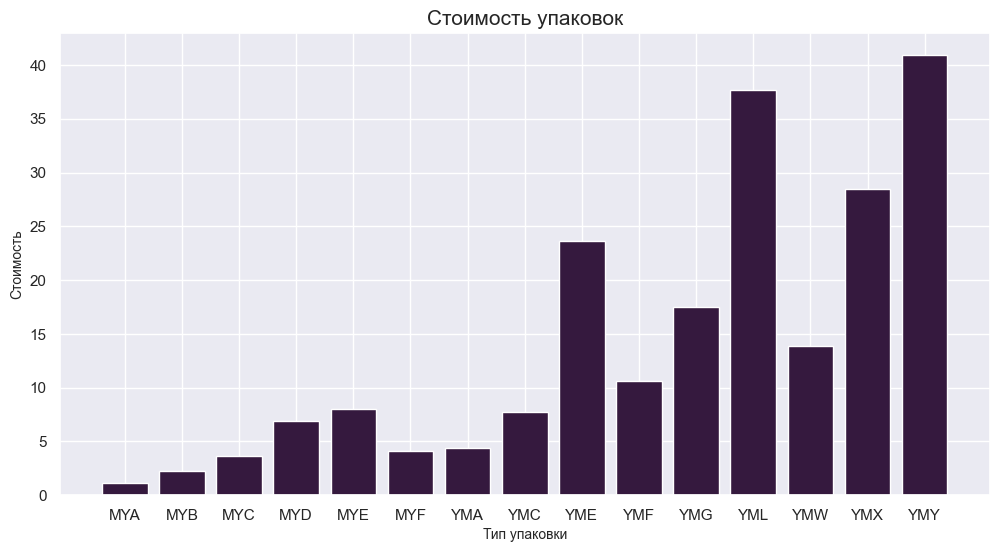

In [12]:
plt.figure(figsize=(12, 6))
plt.bar(carton_price.index,  carton_price.price)
plt.title('Стоимость упаковок')
plt.xlabel('Тип упаковки')
plt.ylabel('Стоимость');

Названия упаковок начинающиеся с `М` - пакетики, стоимость которых в среднем дешевле

#### carton

In [13]:
carton.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CARTONTYPE     29 non-null     object 
 1   LENGTH         29 non-null     float64
 2   WIDTH          29 non-null     float64
 3   HEIGHT         29 non-null     float64
 4   DISPLAYRFPACK  29 non-null     int64  
dtypes: float64(3), int64(1), object(1)
memory usage: 1.3+ KB


In [14]:
carton.columns = carton.columns.str.lower()
carton

,cartontype,length,width,height,displayrfpack
0,YMA,24.7,15.0,10.00,1
1,YMC,30.0,20.0,15.00,1
2,YME,30.0,30.0,44.50,1
3,YMF,35.0,25.0,15.00,1
4,YMG,44.7,30.0,20.00,1
5,YMH,42.0,20.0,86.00,0
6,YMJ,50.0,29.0,48.00,0
7,KSD,0.0,0.0,0.00,0
8,YML,60.0,40.0,45.00,1
9,YMN,60.0,60.0,40.00,0


In [15]:
# carton[['length', 'width', 'height']] = carton[['length', 'width', 'height']].apply(lambda x: -np.sort(-x), raw=True, axis=1)  # сортировка размеров по возрастанию

def multiply_columns(row):
    return row['length'] * row['width'] * row['height']

carton['vol'] = carton[['length', 'width', 'height']].apply(multiply_columns, axis=1)


fig = px.scatter_3d(carton, 
                x='length', 
                y='width', 
                z='height', 
                color='vol'
                )

fig.update_layout(
    width=500, 
    height=500,
    title_text='Распределение размеров и объема коробок'
    )

fig.update_layout(scene_camera=dict(
    eye=dict(x=2.7, y=-1.4, z=1.1),
    center=dict(x=0, y=0, z=0)
))

fig.show()

В данной таблице количество упаковок больше чем представлено в таблице с ценой. Длинна не всегда максимальна относительно других измерений, возможно ориентир относительно стороны открывания, либо данные вводятся случайно. Есть упаковки с `0` в трех измерениях логично для NONPACK & STRETCH. KSD также имеет `0` по всем трем измерениям но в данных для обучения не используется.

displayrfpack - наличие коробки, в работе модели не учитываем

In [16]:
carton[carton['cartontype'].str.startswith(('M'))].describe() # пакеты

,length,width,height,displayrfpack,vol
count,6.000000,6.000000,6.000000,6.0,6.000000
mean,28.000000,36.333333,6.421667,1.0,9373.650000
std,10.936178,18.118131,2.398420,0.0,9923.253967
min,15.000000,15.000000,3.330000,1.0,999.000000
25%,20.500000,23.000000,4.925000,1.0,1987.400000
50%,26.000000,35.000000,6.200000,1.0,5942.800000
75%,36.000000,47.000000,8.000000,1.0,13794.000000
max,43.000000,63.000000,9.700000,1.0,26277.300000


In [17]:
carton[carton['cartontype'].str.startswith(('Y'))].describe() # коробки

,length,width,height,displayrfpack,vol
count,20.00000,20.000000,20.000000,20.000000,20.000000
mean,49.34500,33.125000,37.900000,0.500000,79906.193750
std,18.40459,15.518982,25.616915,0.512989,96818.912079
min,24.70000,15.000000,4.000000,0.000000,2592.000000
25%,36.50000,20.000000,15.000000,0.000000,16781.250000
50%,43.35000,29.500000,40.000000,0.500000,46800.000000
75%,61.25000,41.250000,53.375000,1.000000,81600.000000
max,89.50000,60.000000,86.000000,1.000000,384000.000000


Пакетики всех типов в наличии. По минимальным размерам пакетики и коробки примерно сопоставимы, по максимальным размерам - коробки выигрывают, возможно это компенсируется деформируемостью пакетов.

#### sku_cargotypes

In [18]:
sku_cargotypes.sample(5)

,sku,cargotype
11905343,d0c1dc2089971aad9c95d30f51ee7e20,290
9577072,daf1e4f0bd567dd0430b6e6d146f74e4,200
6416794,d0ffa9bdea4ed054ea85184363d3bdcb,290
2101744,8ab3a79e24f452ed5258a4493fd12731,290
15391287,58f1c65fe6ef7585febe6b6a7f204dcb,480


In [19]:
sku_cargotypes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21053152 entries, 0 to 21053151
Data columns (total 2 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   sku        object
 1   cargotype  int64 
dtypes: int64(1), object(1)
memory usage: 481.9+ MB


In [20]:
print(f'На каждый товар приходится {(sku_cargotypes.shape[0] / sku_cargotypes["sku"].nunique()):.2f} категории')

На каждый товар приходится 3.32 категории


In [21]:
pd.DataFrame(sku_cargotypes['cargotype'].value_counts()).merge(cargotype_info, how='left', on='cargotype').head(20)

,cargotype,count,description
0,290,5216064,Склад МГТ (малогабаритный товар)
1,950,1591250,пачкается
2,200,1009438,техника и электроника
3,970,793449,впитывает запах
4,310,758212,хрупкое
5,600,722025,"одежда, обувь, аксессуары"
6,441,630040,товары для красоты
7,410,615636,опасный Авиа
8,440,545513,косметика и парфюмерия
9,291,524596,Склад СГТ (среднегабаритный товар)


Наиболее популярные категории товаров, техника одежда и косметика. Причем к косметике может относиться `впитывает запах`, `товары для красоты`, `косметика и парфюмерия`, `средства личной гигиены` а также более общие категории: `жидкость`, `опасный Авиа`, `цена средняя`, `Склад СГТ (среднегабаритный товар)`

Похоже что категории товаров принесут слишком много шума в данные и не помогут в обучении модели. Проверим дополнительно далее

#### sku

In [22]:
sku

,sku,a,b,c
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0
1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0
2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0
3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0
4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0
...,...,...,...,...
6385956,5367045e88650a12cde4803f55ed7525,0.0,0.0,0.0
6385957,8a3dcb8f1ccce02a3df63a9db0903f38,0.0,0.0,0.0
6385958,31e5069a999cd927bd623fd699957630,0.0,0.0,0.0
6385959,888059750dcd75922faf3b60144e4def,0.0,0.0,0.0


In [23]:
sku.describe()

,a,b,c
count,6.385961e+06,6.385961e+06,6.385961e+06
mean,2.108468e+01,1.203353e+01,1.782524e+01
std,1.890676e+01,1.487745e+01,1.508838e+01
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+01,3.000000e+00,8.000000e+00
50%,1.800000e+01,8.000000e+00,1.500000e+01
75%,2.800000e+01,1.600000e+01,2.400000e+01
max,6.554000e+03,2.050000e+03,5.930000e+02


Максимальный размер товара значительно превосходит по размерам максимальный размер представленных упаковок. Минимальные размеры 0,0,0 возможно цифровые товары

In [24]:
def multiply_columns(row):
    return row['a'] * row['b'] * row['c']

sku['vol'] = sku[['a', 'b', 'c']].apply(multiply_columns, axis=1)


fig = px.scatter_3d(sku.sample(8000, random_state=RANDOM), 
                x='a', 
                y='b', 
                z='c', 
                color='vol',
                opacity=0.7
                )

fig.update_layout(
    width=500, 
    height=500,
    title_text='Распределение размеров и объема товаров'
    )

fig.update_layout(scene_camera=dict(
    eye=dict(x=2.7, y=-1.4, z=1.1),
    center=dict(x=0, y=0, z=0)
))

fig.show()

Видим, что встречаются как плоские предметы с преобладующими длинной и шириной, так и предметы с преобладающим размеров вдоль одной оси. Чаще всего размеры товаров в пределах 200*100*100

In [25]:
sku.query('vol == 0 & a+b+c > 0').shape[0] # проверка есть ли в катологе ленты Мёбиуса

0

#### data



In [26]:
data

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325618,7,0e4f34db53e37d6bf171c2e055e2b4e0,MYC,1,YMC,MYC,4560,YMC,2080,8525,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,be7c9ad8b9430d358e6c276b94e2beff,f94f078101752133502202383bc87743
325619,7,0e4f34db53e37d6bf171c2e055e2b4e0,MYC,1,YMC,MYC,4560,YMC,2080,8525,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,be7c9ad8b9430d358e6c276b94e2beff,f94f078101752133502202383bc87743
325620,7,e71d2e750ce9a7a39c273c634be1665d,YMC,1,YMC,YMC,8525,YMC,3523,8525,0.284,9db21acf9e6c1a66493c246c1461f989,be7c9ad8b9430d358e6c276b94e2beff,58054d533ef06746ffd8cf99fad4a8cb
325621,7,2e2a642f611b5a6f2c404ab945fbc2a3,MYB,1,YMU,MYB,2816,YMU,552,2592,0.230,4aedb72c5662562524f6119918c7179b,be7c9ad8b9430d358e6c276b94e2beff,1666b5c878be124f05fb9a1d95dd8a68


In [27]:
data.describe()

,whs,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght
count,325623.000000,325623.000000,325623.000000,3.256230e+05,325623.000000,325623.000000
mean,1.366166,2.787773,11188.402656,5.440790e+03,18253.646168,1.134705
std,2.098641,15.774209,13958.516542,2.858190e+04,26745.365119,4.090043
min,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,1.000000,3449.000000,5.000000e+02,3449.000000,0.110000
50%,0.000000,1.000000,8436.000000,1.192000e+03,8525.000000,0.300000
75%,3.000000,1.000000,15579.000000,3.154000e+03,18270.000000,0.799000
max,7.000000,235.000000,108000.000000,1.815450e+06,108000.000000,153.700000


In [28]:
data['box_num'].value_counts().head(10)

box_num
1     296683
2      15199
3       4311
4       1739
5        981
6        503
7        431
10       267
8        248
12       212
Name: count, dtype: int64

Значительно преобладают заказы с 1 коробкой в заказе, встречаются до 235 шт. 

In [29]:
pd.DataFrame(data['selected_cartontype'].value_counts()).merge(carton, how='left', left_on='selected_cartontype', right_on='cartontype').head(20)

,count,cartontype,length,width,height,displayrfpack,vol
0,55937,MYB,22.0,32.0,4.90,1.0,3449.6
1,48837,MYC,30.0,38.0,7.40,1.0,8436.0
2,30497,NONPACK,0.0,0.0,0.00,1.0,0.0
3,27149,YMC,30.0,20.0,15.00,1.0,9000.0
4,24663,MYD,38.0,50.0,8.20,1.0,15580.0
5,23610,YMG,44.7,30.0,20.00,1.0,26820.0
6,20401,MYA,15.0,20.0,3.33,1.0,999.0
7,19256,YMF,35.0,25.0,15.00,1.0,13125.0
8,19173,YMW,40.0,30.0,15.00,1.0,18000.0
9,15795,YMA,24.7,15.0,10.00,1.0,3705.0


Явного преобладания по размерам коробок нет

In [30]:
data.query('selected_cartontype == "YMB"')

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
306135,6,488f30086440836580d685f1d62739d9,YMB,1,YMW,YMB,32722,YMW,7488,21812,1.74,93cde1e32be271140e6974b2f1ad0a1d,cc13d6620f94635b8f376aa2eb70f119,3b6cced2a8d9a7e3e55e81b55559a909
306136,6,488f30086440836580d685f1d62739d9,YMB,1,YMW,YMB,32722,YMW,7488,21812,1.74,93cde1e32be271140e6974b2f1ad0a1d,cc13d6620f94635b8f376aa2eb70f119,3b6cced2a8d9a7e3e55e81b55559a909


## Подготовка данных для обучения модели

Добавим в data тип

In [31]:
all_data = data.merge(sku_cargotypes, on='sku', how='left')

In [32]:
all_data.head()

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid,cargotype
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,290.0
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,600.0
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,610.0
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,950.0
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24,970.0


In [33]:
all_data = all_data[['selected_cartontype', 'cargotype']]

In [34]:
all_data.sample(12)

,selected_cartontype,cargotype
922145,YMF,410.0
1154757,MYC,NaN
532050,YMG,490.0
670185,MYB,340.0
1240638,YMA,410.0
890696,YMW,360.0
645567,YMW,1010.0
1061024,NONPACK,340.0
339888,STRETCH,641.0
1014721,YMC,410.0


Проверим на явные предпочтения коробок и типов

In [35]:
pivot_all_data = all_data.pivot_table(index='selected_cartontype', columns='cargotype', aggfunc=len, fill_value=0) #size
#pivot_all_data = pivot_all_data.apply(lambda x: x / x.sum(), axis=1)
# выбираем 10 наиболее частых cargotype
top_cargo = pivot_all_data.sum().sort_values(ascending=False).head(995).index.tolist()

# фильтруем сводную таблицу по top_cargo и переводим значения в относительные частоты
pivot_all_data = pivot_all_data[top_cargo].apply(lambda x: x / x.sum())
pivot_all_data.columns = pivot_all_data.columns.astype(int)

In [36]:
display(pivot_all_data.loc[:, pivot_all_data.max() >= 0.3].style.format('{:.2f}').background_gradient('coolwarm'))

cargotype,440,291,901,640,292,905,305,301,300,910,908,601,330,302,673,81,799,350,140,315,40,510,900,931,790,110,210,1300,751,20,930
selected_cartontype,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
MYA,0.12,0.01,0.18,0.14,0.00,0.22,0.00,0.00,0.00,0.24,0.31,0.08,0.44,0.00,0.14,0.40,0.07,0.00,0.20,0.01,0.71,0.15,0.26,0.00,0.21,0.00,0.33,0.00,0.00,0.00,0.00
MYB,0.32,0.02,0.35,0.40,0.00,0.42,0.01,0.00,0.00,0.38,0.44,0.37,0.27,0.00,0.39,0.45,0.37,0.00,0.36,0.02,0.17,0.44,0.35,0.26,0.29,0.46,0.50,0.50,1.00,0.00,0.00
MYC,0.18,0.03,0.17,0.16,0.01,0.14,0.02,0.00,0.00,0.19,0.13,0.31,0.09,0.00,0.14,0.07,0.17,0.00,0.14,0.03,0.02,0.22,0.04,0.05,0.36,0.15,0.00,0.25,0.00,1.00,0.00
MYD,0.04,0.07,0.05,0.04,0.01,0.02,0.02,0.00,0.00,0.04,0.03,0.06,0.02,0.00,0.06,0.02,0.09,0.00,0.01,0.05,0.02,0.00,0.04,0.42,0.07,0.00,0.00,0.00,0.00,0.00,0.00
MYE,0.01,0.09,0.02,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.00,0.01,0.00,0.01,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MYF,0.01,0.00,0.01,0.01,0.00,0.01,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.02,0.00,0.02,0.05,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
NONPACK,0.01,0.45,0.02,0.03,0.77,0.00,0.83,0.89,0.90,0.01,0.00,0.01,0.00,0.89,0.00,0.00,0.03,0.96,0.01,0.68,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
STRETCH,0.00,0.25,0.03,0.02,0.19,0.00,0.05,0.09,0.08,0.00,0.00,0.00,0.01,0.11,0.01,0.01,0.01,0.04,0.04,0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
YMA,0.08,0.00,0.05,0.09,0.00,0.08,0.00,0.00,0.00,0.04,0.02,0.01,0.04,0.00,0.07,0.02,0.04,0.00,0.02,0.00,0.00,0.12,0.13,0.05,0.00,0.00,0.00,0.25,0.00,0.00,0.00


Типы товаров в которых препочтение некоторых упаковок значительно преобладает над остальными, добавим их к данным обучения модели

In [37]:
corr_cargo_carton_categ = pivot_all_data.loc[:, pivot_all_data.max() >= 0.5].columns
corr_cargo_carton_categ

Index([292, 305, 301, 300, 302, 350, 315, 40, 210, 1300, 751, 20, 930], dtype='int32', name='cargotype')

In [38]:
sku_cargotypes_filtred = pd.merge(data[['sku']].drop_duplicates(), sku_cargotypes, on='sku', how='left') # дропаем тех которых у нас нет
sku_cargotypes_filtred = sku_cargotypes_filtred.query('cargotype in @corr_cargo_carton_categ') # дропаем слишком шумные
sku_cargotypes_filtred['cargotype'] = sku_cargotypes_filtred['cargotype'].astype('Int64', errors='ignore').fillna(0)

In [39]:
sku_groups = sku_cargotypes_filtred.groupby('sku')['cargotype'].apply(list).reset_index()
sku_groups = pd.merge(data[['sku']].drop_duplicates(), sku_groups, on='sku', how='left').dropna() # 
sku_groups.head()

,sku,cargotype
10,0eabf1bdc973f7721769ded3747e6ce8,[292]
14,c564ff80254cc97773de5668b397780f,[292]
17,d5291922d9d516141e386203e1e7dfc1,[292]
21,1b77f3da72e68eef3c8a73c8932d7bf2,"[292, 300, 301, 302]"
23,06076bee03b035cb460ca9cb680d76f7,[292]


Добавим производные геометрические "фичи"

In [40]:
def gen_geometry_feat(df, a, b, c):
    '''
    генерим геометрические фичи
    a, b, c -- размеры
    '''
    df['dim_sum'] = df[[a, b, c]].sum(axis=1)
    df['vol'] = np.floor(df[[a, b, c]].prod(axis=1))
    df['dim_mean'] = np.floor(df[[a, b, c]].mean(axis=1))
    df['dim_median'] = np.floor(df[[a, b, c]].median(axis=1))

    df['prod_a_b'] = np.floor(df[[a, b]].prod(axis=1))
    df['prod_a_c'] = np.floor(df[[a, c]].prod(axis=1))
    df['prod_b_c'] = np.floor(df[[b, c]].prod(axis=1))
    
    df['prod_min'] = df[['prod_a_b', 'prod_a_c', 'prod_b_c']].min(axis=1)
    df['prod_mean'] = np.floor(df[['prod_a_b', 'prod_a_c', 'prod_b_c']].mean(axis=1))

    df['diag'] = round(np.sqrt(df[a]**2 + df[b]**2 + df[c]**2), 1)
    return df

Отсортируем значения по возрастанию

In [41]:
sku[['a', 'b', 'c']] = sku[['a', 'b', 'c']].apply(lambda x: np.sort(x), raw=True, axis=1) 

In [42]:
sku = gen_geometry_feat(sku, 'a', 'b', 'c')

In [43]:
df = data.copy()

In [44]:
cols_to_drop = ['who', # Лишняя информация
                'trackingid', # Лишняя информация для обучения
                'recommended_cartontype', # Работа прошлого алгоритма - для обучения лишняя инфа
                'recommended_carton', # Дубликат
                'selected_cartontype', # Дубликат 
                'rec_calc_cube', # Результат предсказания
                #'orderkey', 
                'whs' # Не влияет на задачу
                ]

In [45]:
df = df.drop(cols_to_drop, axis=1)
df.head()

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd


Кодируем типы 1,0

In [46]:
mlb = MultiLabelBinarizer()
one_hot = mlb.fit_transform(sku_groups['cargotype'])
one_hot_df = pd.DataFrame(one_hot, columns=mlb.classes_)
one_hot_df['sku'] = sku_groups['sku']

In [47]:
one_hot_df

,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku
0,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
1,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
2,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
3,0,0,0,1,1,1,1,0,0,0,0,0,0,NaN
4,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2629,0,0,0,1,0,0,0,1,0,0,0,0,0,NaN
2630,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN
2631,0,0,0,1,1,1,1,0,0,0,0,0,0,NaN
2632,0,0,0,1,0,0,0,0,0,0,0,0,0,NaN


In [48]:
df = pd.merge(df, one_hot_df, on='sku', how='left')
df = df.fillna(0)

In [49]:
df.describe()

,box_num,sel_calc_cube,pack_volume,goods_wght,20,40,210,292,300,301,302,305,315,350,751,930,1300
count,325623.000000,325623.000000,3.256230e+05,325623.000000,325623.0,325623.0,325623.0,325623.000000,325623.000000,325623.000000,325623.000000,325623.000000,325623.000000,325623.0,325623.0,325623.0,325623.0
mean,2.787773,11188.402656,5.440790e+03,1.134705,0.0,0.0,0.0,0.004855,0.000587,0.000676,0.000181,0.000369,0.000009,0.0,0.0,0.0,0.0
std,15.774209,13958.516542,2.858190e+04,4.090043,0.0,0.0,0.0,0.069511,0.024212,0.025984,0.013460,0.019193,0.003035,0.0,0.0,0.0,0.0
min,1.000000,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,1.000000,3449.000000,5.000000e+02,0.110000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,1.000000,8436.000000,1.192000e+03,0.300000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,1.000000,15579.000000,3.154000e+03,0.799000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,235.000000,108000.000000,1.815450e+06,153.700000,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0


In [50]:
sku = sku[sku['vol']>0]

In [51]:
sku

,sku,a,b,c,vol,dim_sum,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,28.0,31.0,9548.0,70.0,23.0,28.0,308.0,341.0,868.0,308.0,505.0,43.2
1,d9af6ce6f9e303f4b1a8cb47cde21975,14.0,29.0,40.0,16240.0,83.0,27.0,29.0,406.0,560.0,1160.0,406.0,708.0,51.4
2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0,5460.0,60.0,20.0,13.0,156.0,420.0,455.0,156.0,343.0,39.2
3,e8af308a7659e34194770d1e3a48e144,3.0,8.0,13.0,312.0,24.0,8.0,8.0,24.0,39.0,104.0,24.0,55.0,15.6
4,dc0e2542e122731217289b8e6d3bd3f8,18.0,56.0,96.0,96768.0,170.0,56.0,56.0,1008.0,1728.0,5376.0,1008.0,2704.0,112.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6280078,beed9b9bbc5db2fbd2156709e5aa87fe,2.5,30.0,30.0,2250.0,62.5,20.0,30.0,75.0,75.0,900.0,75.0,350.0,42.5
6280079,d19e623480d2daf996f7af7395bcd8d5,5.0,30.0,30.0,4500.0,65.0,21.0,30.0,150.0,150.0,900.0,150.0,400.0,42.7
6280080,7e86666e7d2a64e81d0d3515dece322c,10.0,10.0,20.0,2000.0,40.0,13.0,10.0,100.0,200.0,200.0,100.0,166.0,24.5
6280081,11a4769a51dd25cee8da65245a42cd65,4.0,8.0,18.0,576.0,30.0,10.0,8.0,32.0,72.0,144.0,32.0,82.0,20.1


In [52]:
df = pd.merge(df, sku, on='sku', how='left')
df = df.rename(columns={'vol':'sku_vol', 
                        'a':'sku_a', 
                        'b': 'sku_b',
                        'c': 'sku_c'})

df.head(3)

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,sku_vol,dim_sum,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,2046.0,48.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,2046.0,48.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.1,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,2046.0,48.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4


In [53]:
df.isna().sum()

orderkey               0
box_num                0
selected_carton        0
sel_calc_cube          0
pack_volume            0
goods_wght             0
sku                    0
20                     0
40                     0
210                    0
292                    0
300                    0
301                    0
302                    0
305                    0
315                    0
350                    0
751                    0
930                    0
1300                   0
sku_a              10899
sku_b              10899
sku_c              10899
sku_vol            10899
dim_sum            10899
dim_mean           10899
dim_median         10899
prod_a_b           10899
prod_a_c           10899
prod_b_c           10899
prod_min           10899
prod_mean          10899
diag               10899
dtype: int64

In [54]:
df = df.dropna()
#df = df.query('goods_wght!=0') # metrics 0.3

In [55]:
df

,orderkey,box_num,selected_carton,sel_calc_cube,pack_volume,goods_wght,sku,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,sku_vol,dim_sum,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,2046.0,48.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
1,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,2046.0,48.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
2,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,2046.0,48.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
3,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,2046.0,48.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
4,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,2046,0.100,af49bf330e2cf16e44f0be1bdfe337bd,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,11.0,31.0,2046.0,48.0,16.0,11.0,66.0,186.0,341.0,66.0,197.0,33.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325618,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,20.0,26.0,2080.0,50.0,16.0,20.0,80.0,104.0,520.0,80.0,234.0,33.0
325619,0e4f34db53e37d6bf171c2e055e2b4e0,1,MYC,4560,2080,0.100,86dcc1a44eb2939fea4d2dd3604e1f9e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,20.0,26.0,2080.0,50.0,16.0,20.0,80.0,104.0,520.0,80.0,234.0,33.0
325620,e71d2e750ce9a7a39c273c634be1665d,1,YMC,8525,3523,0.284,9db21acf9e6c1a66493c246c1461f989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,11.4,30.3,3523.0,51.9,17.0,11.0,116.0,309.0,345.0,116.0,256.0,33.9
325621,2e2a642f611b5a6f2c404ab945fbc2a3,1,MYB,2816,552,0.230,4aedb72c5662562524f6119918c7179b,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,23.0,552.0,37.0,12.0,12.0,24.0,46.0,276.0,24.0,115.0,26.0


Так как чаще всего преобладают заказы с одним типом товара группируем и суммируем таблицу по заказу

In [56]:
df_sum = df.drop(['selected_carton', 'sku'], axis=1).groupby('orderkey', sort=False).sum() # суммируем по заказам

In [57]:
df_sum

,box_num,sel_calc_cube,pack_volume,goods_wght,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,sku_vol,dim_sum,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag
orderkey,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0,451.0,1271.0,83886.0,1968.0,656.0,451.0,2706.0,7626.0,13981.0,2706.0,8077.0,1369.4
4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,18.6,49.7,3050.0,71.6,23.0,18.0,61.0,164.0,924.0,61.0,383.0,53.2
3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,23.0,30.0,15180.0,75.0,25.0,23.0,506.0,660.0,690.0,506.0,618.0,43.7
7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.7,14.0,43.8,6561.0,68.5,22.0,14.0,149.0,468.0,613.0,149.0,410.0,47.2
097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,23.4,33.9,6346.0,65.3,21.0,23.0,187.0,271.0,793.0,187.0,417.0,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,88.0,88.0,50336.0,202.0,66.0,88.0,1144.0,1144.0,3872.0,1144.0,2052.0,127.2
0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,40.0,52.0,4160.0,100.0,32.0,40.0,160.0,208.0,1040.0,160.0,468.0,66.0
e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,11.4,30.3,3523.0,51.9,17.0,11.0,116.0,309.0,345.0,116.0,256.0,33.9


In [58]:
# возвращаем потеряный таргет
order_pack = df[['orderkey', 'selected_carton']].drop_duplicates()
df_sum = pd.merge(df_sum, order_pack, on= 'orderkey', how='left')

In [59]:
# # добавляем максимальные размеры одного товара в итог не повлияло
# df_grouped = df.groupby('orderkey', sort=False)[['sku_a', 'sku_b', 'sku_c', 'goods_wght']].max().reset_index() 
# df_grouped['sku_max_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].sum(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
# df_grouped['sku_mean_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].mean(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
# df_grouped['sku_prod_size'] = df_grouped[['sku_a', 'sku_b', 'sku_c']].prod(axis=1) # df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)
# # ratio max к остальным
# df_grouped['sku_ratio_max_a'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_a']), 1)
# df_grouped['sku_ratio_max_b'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_b']), 1)
# df_grouped['sku_ratio_max_c'] = round(np.divide(df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1), df_grouped['sku_c']), 1)
# # weight
# df_grouped['dens'] = round(np.divide(df_grouped['goods_wght']*10**4, df_grouped['sku_prod_size']), 1)
# df_grouped['wght_max_len'] = round(np.divide(df_grouped['goods_wght']*10**3, df_grouped[['sku_a', 'sku_b', 'sku_c']].max(axis=1)), 1)

# df_grouped['sku_max_diag'] = round(np.sqrt(df_grouped['sku_a']**2 + df_grouped['sku_b']**2 + df_grouped['sku_c']**2), 1)
# df_grouped['sku_max_diag'] = round(np.sqrt(df['sku_a']**2 + df['sku_b']**2 + df['sku_c']**2), 1)

# df_sum = pd.merge(df_sum, df_grouped[['orderkey', 'sku_max_size', 'sku_mean_size', 
#                                   'sku_prod_size', 'sku_ratio_max_a', 'sku_ratio_max_b', 
#                                   'sku_ratio_max_c', 'dens', 'wght_max_len', 'sku_max_diag']], on='orderkey', how='left')

In [60]:
df_sum

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,sku_vol,dim_sum,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton
0,d48f3211c1ffccdc374f23139a9ab668,64,0,83886,4.100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,246.0,451.0,1271.0,83886.0,1968.0,656.0,451.0,2706.0,7626.0,13981.0,2706.0,8077.0,1369.4,NONPACK
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,18.6,49.7,3050.0,71.6,23.0,18.0,61.0,164.0,924.0,61.0,383.0,53.2,STRETCH
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,23.0,30.0,15180.0,75.0,25.0,23.0,506.0,660.0,690.0,506.0,618.0,43.7,STRETCH
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.7,14.0,43.8,6561.0,68.5,22.0,14.0,149.0,468.0,613.0,149.0,410.0,47.2,STRETCH
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,23.4,33.9,6346.0,65.3,21.0,23.0,187.0,271.0,793.0,187.0,417.0,42.0,STRETCH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155344,8ed0af8473526c54b4b2f99f0060c3ea,2,0,50336,2.520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,88.0,88.0,50336.0,202.0,66.0,88.0,1144.0,1144.0,3872.0,1144.0,2052.0,127.2,NONPACK
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,40.0,52.0,4160.0,100.0,32.0,40.0,160.0,208.0,1040.0,160.0,468.0,66.0,MYC
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,11.4,30.3,3523.0,51.9,17.0,11.0,116.0,309.0,345.0,116.0,256.0,33.9,YMC
155347,2e2a642f611b5a6f2c404ab945fbc2a3,1,2816,552,0.230,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,12.0,23.0,552.0,37.0,12.0,12.0,24.0,46.0,276.0,24.0,115.0,26.0,MYB


Удалим выбросы по объему

In [63]:
df = df.drop('orderkey', axis=1)

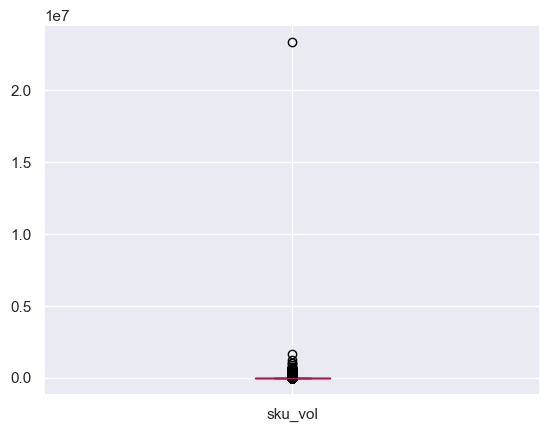

In [64]:
df_sum['sku_vol'].plot(kind='box');

In [65]:
# дроп выбросов по объему
q1 = df_sum['sku_vol'].quantile(0.25)
q3 = df_sum['sku_vol'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_no_outlier_vol = df_sum[(df_sum['sku_vol'] >= lower_bound) & (df_sum['sku_vol'] <= upper_bound)]

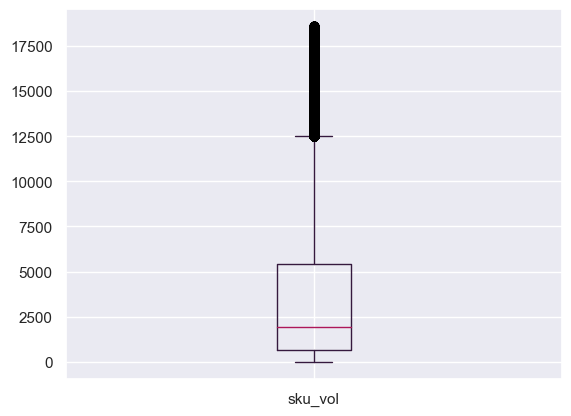

In [66]:
df_no_outlier_vol['sku_vol'].plot(kind='box');

In [68]:
df_no_outlier_vol

,orderkey,box_num,sel_calc_cube,pack_volume,goods_wght,20,40,210,292,300,301,302,305,315,350,751,930,1300,sku_a,sku_b,sku_c,sku_vol,dim_sum,dim_mean,dim_median,prod_a_b,prod_a_c,prod_b_c,prod_min,prod_mean,diag,selected_carton
1,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,0,3050,0.896,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.3,18.6,49.7,3050.0,71.6,23.0,18.0,61.0,164.0,924.0,61.0,383.0,53.2,STRETCH
2,3e646181f6f708edd3326c1626c12d23,1,0,13662,4.400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0,23.0,30.0,15180.0,75.0,25.0,23.0,506.0,660.0,690.0,506.0,618.0,43.7,STRETCH
3,7047c16a6b7c120162ca3da0ebca43fd,1,0,4518,0.700,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.7,14.0,43.8,6561.0,68.5,22.0,14.0,149.0,468.0,613.0,149.0,410.0,47.2,STRETCH
4,097917e584151c0c21f205b2c3aafa10,1,0,6346,2.078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,23.4,33.9,6346.0,65.3,21.0,23.0,187.0,271.0,793.0,187.0,417.0,42.0,STRETCH
6,abea12f00a205457b289b2e5c0351e17,1,0,7569,6.080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,29.0,29.0,7569.0,67.0,22.0,29.0,261.0,261.0,841.0,261.0,454.0,42.0,NONPACK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155342,3acc4b901256bcd9f333b6978864773b,1,8525,4050,1.740,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,18.0,25.0,4050.0,52.0,17.0,18.0,162.0,225.0,450.0,162.0,279.0,32.1,YMC
155343,b2d5108421ce9c823a083fdaf870b9a2,6,130872,12510,1.236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.6,142.2,251.4,12510.0,406.2,132.0,138.0,294.0,522.0,5958.0,294.0,2256.0,289.2,YMW
155345,0e4f34db53e37d6bf171c2e055e2b4e0,2,9120,4160,0.200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,40.0,52.0,4160.0,100.0,32.0,40.0,160.0,208.0,1040.0,160.0,468.0,66.0,MYC
155346,e71d2e750ce9a7a39c273c634be1665d,1,8525,3523,0.284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.2,11.4,30.3,3523.0,51.9,17.0,11.0,116.0,309.0,345.0,116.0,256.0,33.9,YMC


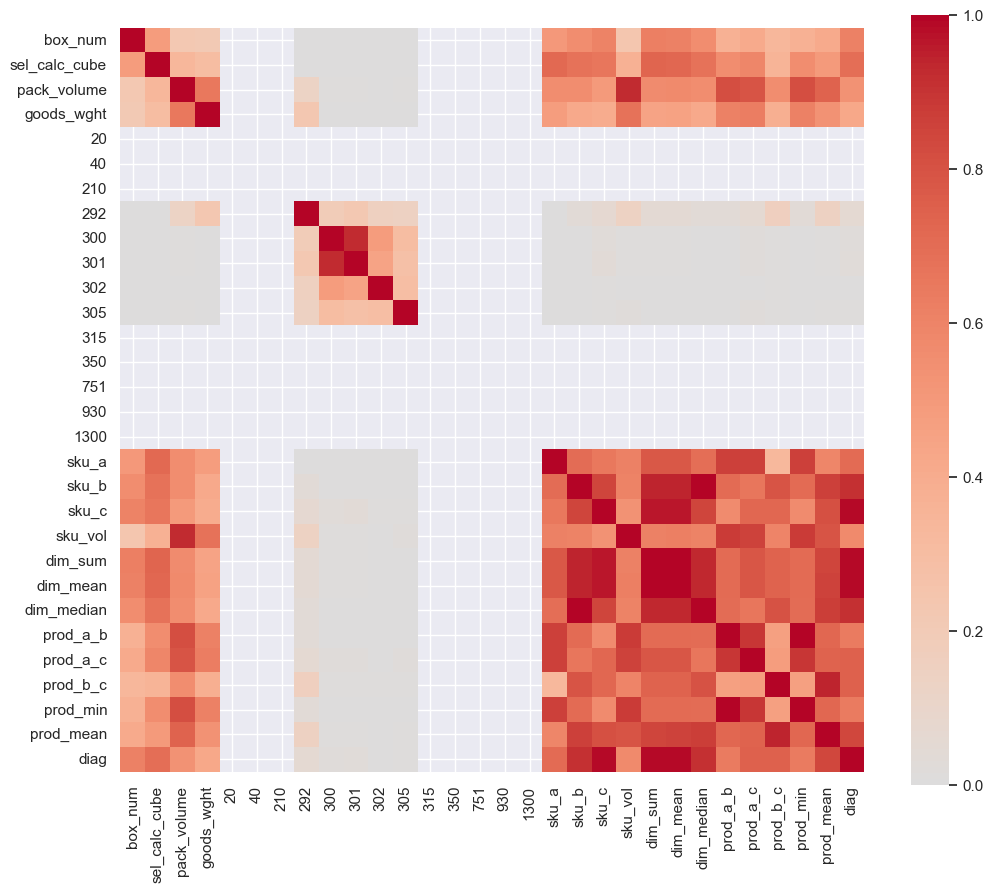

In [69]:
numeric_columns = df_no_outlier_vol.loc[:,df_no_outlier_vol.dtypes!=np.object_].columns

plt.figure(figsize=(12, 10))
sns.heatmap(df_no_outlier_vol[numeric_columns].corr(), 
            #annot=True, 
            vmin=0, 
            vmax=1, 
            center=0, 
            cmap='coolwarm', 
            square=True);

Есть мультикоррелирующие признаки между собой, модель используется с регуляризацией оставляем как есть

In [70]:
corr_feat = set()
corr_matrix = df_no_outlier_vol[numeric_columns].corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.85:
            colname = corr_matrix.columns[i]
            corr_feat.add(colname)       
corr_feat

{301,
 'diag',
 'dim_mean',
 'dim_median',
 'dim_sum',
 'prod_a_b',
 'prod_a_c',
 'prod_mean',
 'prod_min',
 'sku_vol'}

In [71]:
# # drop не повышает качесвто
# df_no_outlier_vol = df_no_outlier_vol.drop(corr_feat, axis=1)

Данные подготовлены, испробованы разные их сочетания, переходим к обучению модели

# Модель 1

In [74]:
df_no_outlier_vol = df_no_outlier_vol.query('selected_carton != "YMB"') # один случай дропаем из-за stratify

In [75]:
df_no_outlier_vol = df_no_outlier_vol.dropna()

In [76]:
df_no_outlier_vol['selected_carton'].value_counts()

selected_carton
MYB        39508
MYC        29030
MYA        14361
MYD        12776
YMC         7919
NONPACK     7823
YMA         6730
STRETCH     5321
YMF         4036
MYE         3960
YMW         3407
YMG         2560
MYF          790
YME          322
YMX           29
YML            7
Name: count, dtype: int64

In [77]:
X = df_no_outlier_vol.drop(['sel_calc_cube', 'box_num', 'pack_volume', 'selected_carton', 'orderkey'], axis=1)
X.columns = X.columns.astype(str)
y = df_no_outlier_vol['selected_carton']


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25, 
                                                    random_state=RANDOM,
                                                    shuffle=True,
                                                    stratify=df_no_outlier_vol['selected_carton']
                                                    )

In [78]:
categorical = list(corr_cargo_carton_categ.astype(str))
print(f"Категориальные признаки: {categorical}")

numerical = list(set(X_train.columns) - set(categorical))
print(f"Числовые признаки: {numerical}")

Категориальные признаки: ['292', '305', '301', '300', '302', '350', '315', '40', '210', '1300', '751', '20', '930']
Числовые признаки: ['prod_mean', 'dim_mean', 'sku_vol', 'goods_wght', 'diag', 'prod_min', 'prod_b_c', 'dim_sum', 'sku_b', 'dim_median', 'sku_c', 'prod_a_c', 'sku_a', 'prod_a_b']


In [80]:
# classes = np.unique(y_train)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# class_weights = dict(zip(classes, weights))

In [81]:
tree_pipe = Pipeline([
    #('scaler', StandardScaler()),
    #('scaler', RobustScaler()),
    #('pca', PCA(n_components=6)),
    #('kmeans', KMeans(n_clusters=5)),
    #('nb', MLPClassifier(verbose=True)),


    
    ('tree', CatBoostClassifier(
        random_state=42,
        #early_stopping_rounds=100,
        #learning_rate=0.01, 
        #leaf_estimation_method='Gradient',
        iterations=500,
        #subsample=0.1,
        #max_depth=5,
        verbose=10,
        #l2_leaf_reg = 7,
        #bootstrap_type="Bernoulli",
        #class_weights=class_weights,
        loss_function='MultiClass',
        eval_metric='AUC',
        #cat_features=corr_cargo_carton_categ.to_list()
        ))
])

tree_pipe.fit(X_train, y_train)

Learning rate set to 0.180114
0:	total: 463ms	remaining: 3m 51s
10:	total: 4.58s	remaining: 3m 23s
20:	total: 7.35s	remaining: 2m 47s
30:	total: 10s	remaining: 2m 31s
40:	total: 12.9s	remaining: 2m 24s
50:	total: 15.9s	remaining: 2m 20s
60:	total: 18.5s	remaining: 2m 13s
70:	total: 22s	remaining: 2m 13s
80:	total: 24.9s	remaining: 2m 8s
90:	total: 28.9s	remaining: 2m 9s
100:	total: 32.6s	remaining: 2m 8s
110:	total: 37s	remaining: 2m 9s
120:	total: 41s	remaining: 2m 8s
130:	total: 45.5s	remaining: 2m 8s
140:	total: 49.9s	remaining: 2m 7s
150:	total: 54.3s	remaining: 2m 5s
160:	total: 59s	remaining: 2m 4s
170:	total: 1m 3s	remaining: 2m 2s
180:	total: 1m 9s	remaining: 2m 1s
190:	total: 1m 12s	remaining: 1m 57s
200:	total: 1m 16s	remaining: 1m 53s
210:	total: 1m 19s	remaining: 1m 48s
220:	total: 1m 22s	remaining: 1m 44s
230:	total: 1m 25s	remaining: 1m 39s
240:	total: 1m 28s	remaining: 1m 35s
250:	total: 1m 31s	remaining: 1m 31s
260:	total: 1m 34s	remaining: 1m 26s
270:	total: 1m 37s	rem

Pipeline(steps=[('tree',
                 <catboost.core.CatBoostClassifier object at 0x0000023197B4A950>)])

Text(0.5, 1.0, 'Feature Importance')

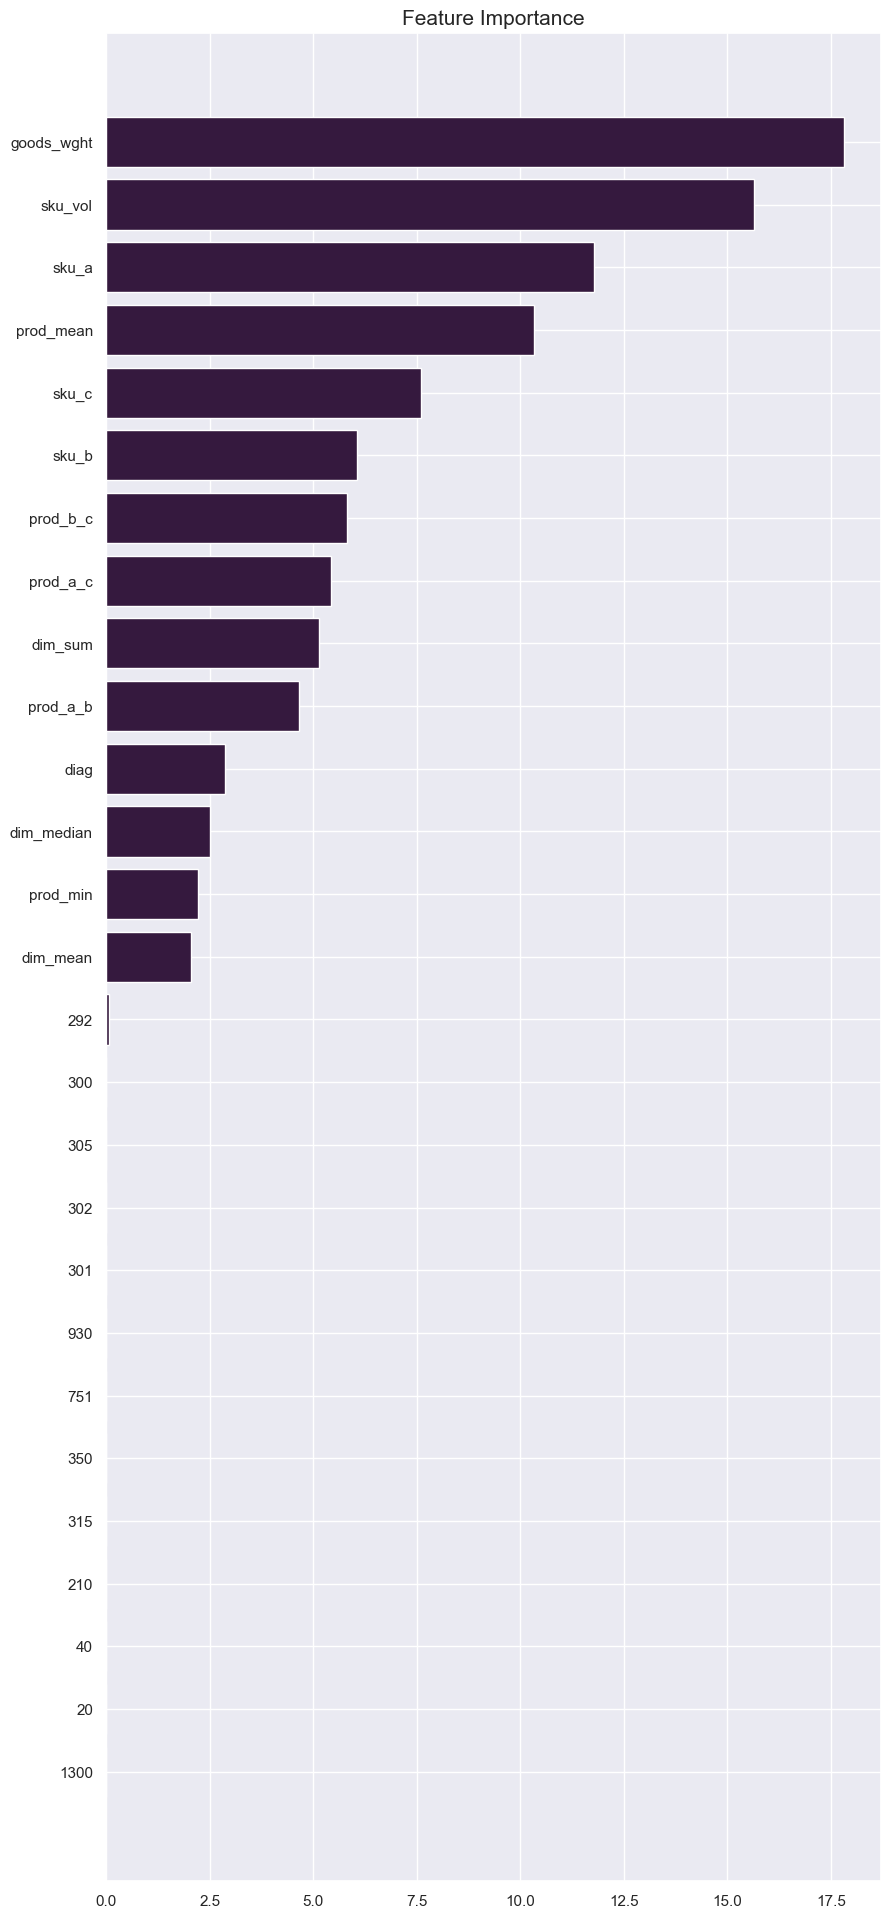

In [82]:
feature_importance = tree_pipe.named_steps['tree'].get_feature_importance()
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(10, 24))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_test.columns)[sorted_idx])
plt.title('Feature Importance')

Самыми важными параметрами для модели является вес и объем

In [83]:

tree_preds = tree_pipe.predict(X_test)
tree_pred_proba = tree_pipe.predict_proba(X_test)

print(f'TRAIN ACC: {accuracy_score(y_train, tree_pipe.predict(X_train))}')
print(f'TEST ACC: {accuracy_score(y_test, tree_preds)}')
print(f'TEST F1: {f1_score(y_test, tree_preds, average="weighted")}')
print(f'AUC: {roc_auc_score(y_test, tree_pred_proba, average="weighted", multi_class="ovr")}')

print(classification_report(y_test, tree_preds))

TRAIN ACC: 0.5234187080262475
TEST ACC: 0.49242314908356183
TEST F1: 0.478757673144824
AUC: 0.8536051655380852
              precision    recall  f1-score   support

         MYA       0.56      0.44      0.49      3590
         MYB       0.60      0.70      0.64      9877
         MYC       0.49      0.54      0.52      7258
         MYD       0.36      0.45      0.40      3194
         MYE       0.25      0.11      0.15       990
         MYF       0.00      0.00      0.00       197
     NONPACK       0.50      0.54      0.52      1956
     STRETCH       0.35      0.22      0.27      1330
         YMA       0.46      0.16      0.24      1683
         YMC       0.39      0.36      0.37      1980
         YME       0.00      0.00      0.00        80
         YMF       0.30      0.25      0.27      1009
         YMG       0.37      0.35      0.36       640
         YML       0.00      0.00      0.00         2
         YMW       0.29      0.33      0.31       852
         YMX       0.00 

Качество модели по оценке AUC: 0.8536051655380852, вполне не плохо.

Пример выдачи для двух вариантов - в прод не пошло, неизвестно какой вариант буде выбирать работник

In [84]:
y_proba = tree_pipe.predict_proba(X_test[100:110])

# два наиболее вероятных класса с вероятностями
top_two = y_proba.argsort()[:, -2:]
top_two_proba = np.round(np.sort(y_proba, axis=1)[:, -2:], 2)

# результаты предсказания
for i in range(len(X_test[100:110])):
    class_names = tree_pipe.classes_[top_two[i]]
    print(f"Для заказа № {i} рекомендуется упаковка: {class_names[0]}, {top_two_proba[i][0]*100}% или {class_names[1]}, {top_two_proba[i][1]*100}%, тест {y_test.iloc[i]}")

Для заказа № 0 рекомендуется упаковка: YMW, 19.0% или YMG, 37.0%, тест MYC
Для заказа № 1 рекомендуется упаковка: MYB, 21.0% или MYC, 47.0%, тест MYA
Для заказа № 2 рекомендуется упаковка: MYB, 35.0% или MYC, 45.0%, тест MYD
Для заказа № 3 рекомендуется упаковка: MYB, 37.0% или MYA, 55.00000000000001%, тест YMW
Для заказа № 4 рекомендуется упаковка: YMG, 20.0% или YMW, 38.0%, тест MYC
Для заказа № 5 рекомендуется упаковка: MYA, 38.0% или MYB, 48.0%, тест MYB
Для заказа № 6 рекомендуется упаковка: MYD, 20.0% или YMC, 31.0%, тест MYB
Для заказа № 7 рекомендуется упаковка: NONPACK, 31.0% или STRETCH, 33.0%, тест MYB
Для заказа № 8 рекомендуется упаковка: MYC, 37.0% или MYB, 54.0%, тест MYC
Для заказа № 9 рекомендуется упаковка: MYD, 15.0% или YMF, 30.0%, тест MYD


# ВЫВОД

В данной работе проведено исследование данных об упаковке товаров. Нами построена модель для предсказания типа упаковки на основе данных о выборе упаковок работниками склада. Полученное качество на основе метрики ROCAUC составляет 0,85. Параметры модели:

In [85]:
tree_pipe.named_steps["tree"].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'AUC',
 'iterations': 500,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'eval_fraction': 0,
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'use_best_model': False,
 'class_names': ['MYA',
  'MYB',
  'MYC',
  'MYD',
  'MYE',
  'MYF',
  'NONPACK',
  'STRETCH',
  'YMA',
  'YMC',
  'YME',
  'YMF',
  'YMG',
  'YML',
  'YMW',
  'YMX'],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'bagging_temperature': 1,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
